# Assignment 5: Image Compression via Block-wise SVD

## Objective
Explore Singular Value Decomposition (SVD) for compressing grayscale images using a block-wise approach. Analyze how image quality and compression ratio evolve with the number of singular values retained (`k`).

## Import Libraries

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Ensure plots appear inline in the notebook
%matplotlib inline

## Configuration

In [15]:
# --- Configuration ---
# <<< CHANGE THIS TO YOUR IMAGE FILENAME >>>
image_filename = 'image.jpg'
output_dir = 'reconstructed_images'
# --------------------

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

## Phase 1: Preprocessing

In this phase, we will:
1. Load the image
2. Convert it to grayscale (if needed)
3. Crop/resize to ensure dimensions are divisible by 8 (required for 8×8 blocks)
4. Convert to NumPy array for numerical processing

In [16]:
def preprocess_image(filename):
    """Loads, converts to grayscale, and crops the image to dimensions divisible by 8."""
    # Check if the image file exists
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Error: Image file '{filename}' not found. \n"
                            f"Please make sure the image is in the same directory as the notebook \n"
                            f"or provide the correct path.")

    # Load the image
    img = Image.open(filename)

    # Convert to grayscale
    img_gray = img.convert('L')

    # Get dimensions
    width, height = img_gray.size
    print(f"Original dimensions: {width}x{height}")

    # Calculate new dimensions divisible by 8
    new_width = width // 8 * 8
    new_height = height // 8 * 8

    # Crop the image if necessary
    if new_width != width or new_height != height:
        print(f"Cropping to: {new_width}x{new_height}")
        # Crop from top-left corner
        img_cropped = img_gray.crop((0, 0, new_width, new_height))
    else:
        img_cropped = img_gray
        print("Dimensions are already divisible by 8.")

    # Convert to NumPy array (using float for SVD precision)
    img_array = np.array(img_cropped, dtype=float)

    print(f"Processed image array shape: {img_array.shape}")
    
    return img_array

Original dimensions: 512x512
Dimensions are already divisible by 8.
Processed image array shape: (512, 512)


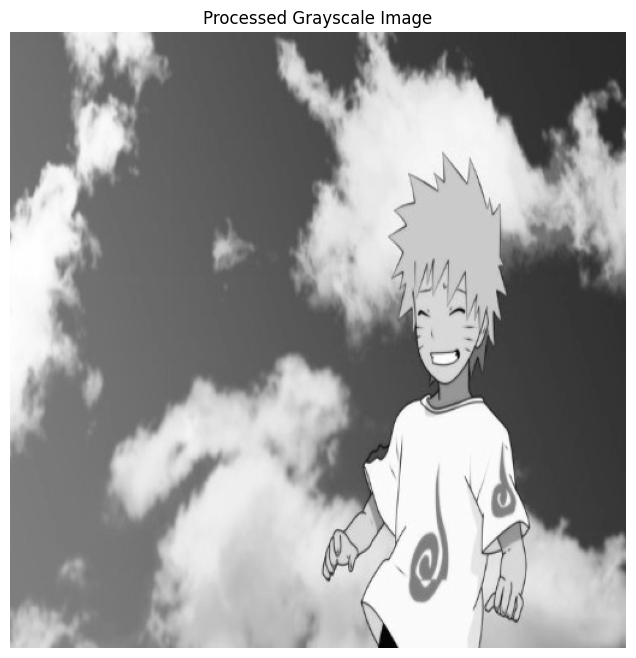

In [17]:
# Execute preprocessing
img_array = preprocess_image(image_filename)

# Display the processed grayscale image
plt.figure(figsize=(8, 8))
plt.imshow(img_array, cmap='gray')
plt.title("Processed Grayscale Image")
plt.axis('off')  # Hide axes ticks
plt.show()

## Phase 2: Block-wise SVD Function

We will implement two key functions:
1. `compress_block(block, k)`: Apply SVD to an 8×8 block, keep top-k singular values
2. `apply_block_svd(img_array, k)`: Process the entire image, block by block

### SVD Reminder
SVD decomposes a matrix A into three components: A = U·Σ·V^T where:
- U contains left singular vectors (orthogonal columns)
- Σ is a diagonal matrix of singular values (in descending order)
- V^T contains right singular vectors (orthogonal rows)

By keeping only the top-k singular values, we can approximate the original matrix.

In [18]:
def compress_block(block, k):
    """Applies SVD to an 8x8 block and reconstructs it using the top k singular values."""
    if k < 1 or k > 8:
        raise ValueError("k must be between 1 and 8")
        
    # Apply SVD
    U, s, Vh = np.linalg.svd(block)
    
    # Truncate: Keep only the top k components
    U_k = U[:, :k]        # First k columns of U
    s_k = s[:k]          # First k singular values
    Vh_k = Vh[:k, :]     # First k rows of Vh (which is V transpose)
    
    # Reconstruct the block
    # Note: s_k is 1D, need to make it a diagonal matrix for multiplication
    reconstructed_block = U_k @ np.diag(s_k) @ Vh_k
    
    return reconstructed_block

def apply_block_svd(img_array, k):
    """Applies block-wise SVD compression to the entire image."""
    height, width = img_array.shape
    reconstructed_image = np.zeros_like(img_array) # Create an empty array for the result
    
    # Iterate through the image in 8x8 blocks
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Extract the 8x8 block
            block = img_array[i:i+8, j:j+8]
            
            # Compress the block using SVD
            reconstructed_block = compress_block(block, k)
            
            # Place the reconstructed block back into the result image
            reconstructed_image[i:i+8, j:j+8] = reconstructed_block
            
    return reconstructed_image

## Phase 3: Compression Analysis

Now we will run the compression for `k` values from 1 to 8 and analyze the results.

For each value of `k`, we will:
1. Apply the block-wise SVD compression
2. Calculate the compression ratio
3. Calculate the reconstruction error (Frobenius norm)
4. Save the reconstructed image

### Compression Ratio Calculation:
- Original data per 8×8 block = 64 values
- Retained data per block = k * (8 + 8 + 1) = 17k values
- Compression Ratio = 64 / (17k)

In [19]:
k_values = list(range(1, 9)) # k from 1 to 8
compression_ratios = []
reconstruction_errors = []
reconstructed_images = {}

print("Starting compression analysis...")

for k in k_values:
    print(f"Processing for k={k}...")
    
    # Apply block-wise SVD
    reconstructed_image_k = apply_block_svd(img_array, k)
    reconstructed_images[k] = reconstructed_image_k
    
    # --- Calculate Compression Ratio ---
    original_data_per_block = 8 * 8  # 64 values
    # Stored data: k singular values + k*8 values for U_k + k*8 values for Vh_k
    # Data retained = k * (m + n + 1) for an m x n block. Here m=8, n=8.
    retained_data_per_block = k * (8 + 8 + 1)  # 17*k values 
    ratio = original_data_per_block / retained_data_per_block
    compression_ratios.append(ratio)
    print(f"  k={k}, Compression Ratio: {ratio:.2f}")
    
    # --- Calculate Reconstruction Error (Frobenius Norm) ---
    diff = img_array - reconstructed_image_k
    error = np.linalg.norm(diff, 'fro')
    reconstruction_errors.append(error)
    print(f"  k={k}, Reconstruction Error (Frobenius): {error:.2f}")
    
    # --- Save Reconstructed Image ---
    # Clip values to [0, 255] and convert to uint8 for saving
    clipped_image = np.clip(reconstructed_image_k, 0, 255)
    final_image_data = clipped_image.astype(np.uint8)
    
    # Convert back to PIL Image
    img_to_save = Image.fromarray(final_image_data)
    
    # Save the image
    save_path = os.path.join(output_dir, f'reconstructed_k{k}.png')
    img_to_save.save(save_path)
    print(f"  Saved reconstructed image to: {save_path}")
    
print("\nCompression analysis complete.")

Starting compression analysis...
Processing for k=1...
  k=1, Compression Ratio: 3.76
  k=1, Reconstruction Error (Frobenius): 4056.12
  Saved reconstructed image to: reconstructed_images\reconstructed_k1.png
Processing for k=2...
  k=2, Compression Ratio: 1.88
  k=2, Reconstruction Error (Frobenius): 2132.99
  Saved reconstructed image to: reconstructed_images\reconstructed_k2.png
Processing for k=3...
  k=3, Compression Ratio: 1.25
  k=3, Reconstruction Error (Frobenius): 1097.81
  Saved reconstructed image to: reconstructed_images\reconstructed_k3.png
Processing for k=4...
  k=4, Compression Ratio: 0.94
  k=4, Reconstruction Error (Frobenius): 581.31
  Saved reconstructed image to: reconstructed_images\reconstructed_k4.png
Processing for k=5...
  k=5, Compression Ratio: 0.75
  k=5, Reconstruction Error (Frobenius): 264.78
  Saved reconstructed image to: reconstructed_images\reconstructed_k5.png
Processing for k=6...
  k=6, Compression Ratio: 0.63
  k=6, Reconstruction Error (Frobeni

## Phase 4: Visualization

Let's visualize the results in two ways:
1. Plot of Compression Ratio vs. k
2. Plot of Reconstruction Error vs. k

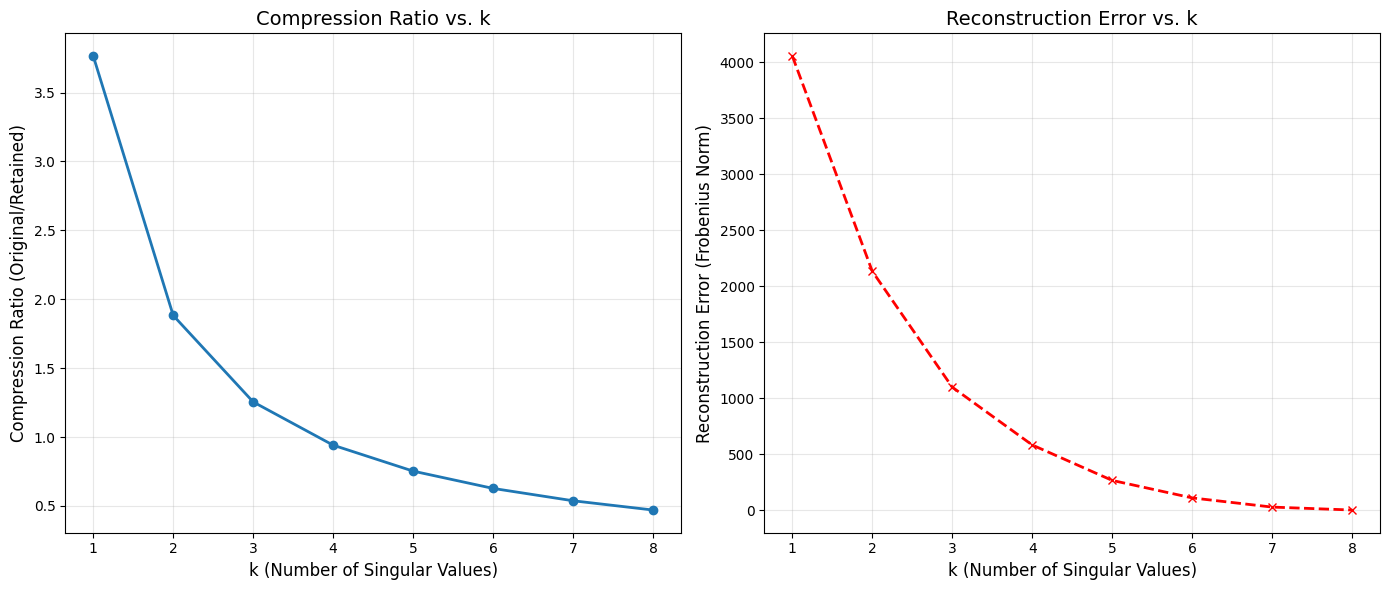

In [20]:
# Create plots
plt.figure(figsize=(14, 6))

# Plot Compression Ratio vs. k
plt.subplot(1, 2, 1)
plt.plot(k_values, compression_ratios, marker='o', linestyle='-', linewidth=2)
plt.title('Compression Ratio vs. k', fontsize=14)
plt.xlabel('k (Number of Singular Values)', fontsize=12)
plt.ylabel('Compression Ratio (Original/Retained)', fontsize=12)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

# Plot Reconstruction Error vs. k
plt.subplot(1, 2, 2)
plt.plot(k_values, reconstruction_errors, marker='x', linestyle='--', color='r', linewidth=2)
plt.title('Reconstruction Error vs. k', fontsize=14)
plt.xlabel('k (Number of Singular Values)', fontsize=12)
plt.ylabel('Reconstruction Error (Frobenius Norm)', fontsize=12)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_plots.png')
plt.show()

## Visual Comparison of Reconstructed Images

Now let's display the original image alongside a selection of reconstructed images with different k values.

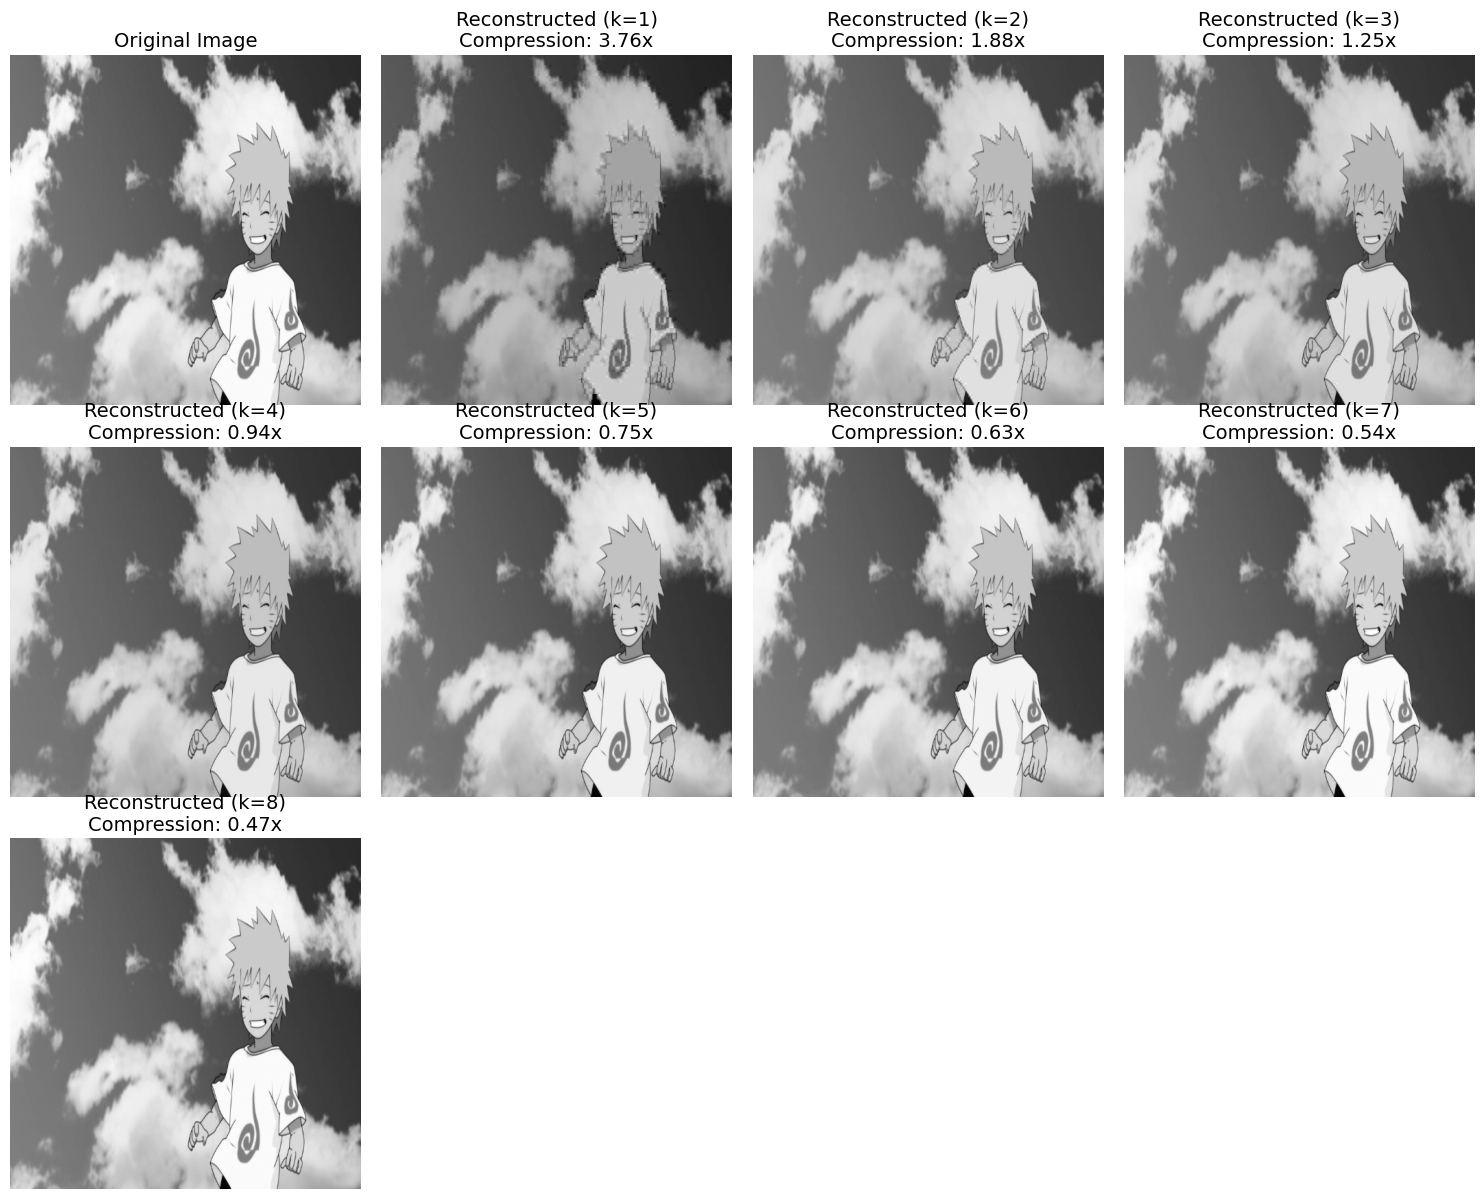

In [26]:
# Display a visual comparison for selected k values
k_to_display = [1, 2,3, 4,5,6,7 ,8]  # Choose which k values to display

plt.figure(figsize=(15, 12))

# Display original image
plt.subplot(3, 4, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image", fontsize=14)
plt.axis('off')

# Display reconstructed images
for i, k in enumerate(k_to_display):
    plt.subplot(3, 4, i+2)
    plt.imshow(reconstructed_images[k], cmap='gray')
    plt.title(f"Reconstructed (k={k})\nCompression: {compression_ratios[k-1]:.2f}x", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.savefig('visual_comparison.png')
plt.show()

## Analysis and Observations


- As k increases from 1 to 8, the compression ratio decreases from approximately 3.76 to 0.47, indicating that we store more data as we retain more singular values.
- The reconstruction error decreases as k increases, with a significant drop between k=1 and k=2, suggesting that even just using 2 singular values can capture much of the image information.
- Visually, images with k≥4 appear to retain most of the important visual features, while k=1 loses significant detail.
- A good balance between compression and quality might be around k=3 or k=4, depending on the specific image.